# YOLO Boat Detection: Training Notebook

This notebook demonstrates how to train a YOLO model to detect boats in open water using a preprocessed dataset (auto-orient, resize 640x640, random noise, and rotations) located in `/dataset`.

**Outline:**
1. Import Required Libraries
2. Load and Inspect the Dataset
3. Prepare YOLO-Compatible Dataset Structure
4. Configure YOLO Model and Training Parameters
5. Train the YOLO Model
6. Visualize Training Metrics
7. Evaluate Model Performance on Validation Data
8. Run Inference on Sample Images

In [1]:
# 1. Import Required Libraries
import os
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

## 2. Load and Inspect the Dataset

Let's visualize a few random images and their labels to verify preprocessing and augmentation. 

**Dataset details:**
- Exported from Roboflow (Jan 30, 2026)
- 116 images, YOLOv11 format
- Preprocessing: auto-orientation, resize to 640x640 (stretch)
- Augmentation: random rotation (-10° to +10°), salt & pepper noise (0.14% pixels), 3 versions per image
- Already split into train, valid, and test sets

For more info and state-of-the-art notebooks, see: https://github.com/roboflow/notebooks

Image: IM_02900_JPG.rf.aecfac5f9247005cddbc6ab376a65a17.jpg


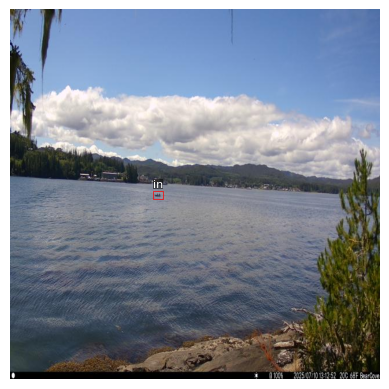

Image: IM_03846_JPG.rf.fbb90d4f54a9cfa1020c2f056aaf162b.jpg


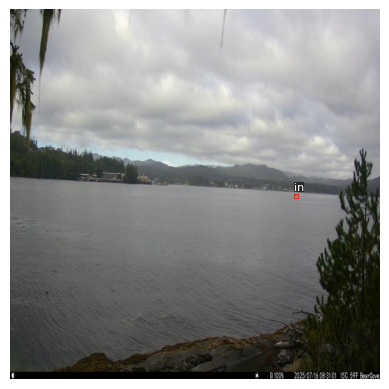

Image: IM_02237_JPG.rf.566c053433f344965822690f54532f24.jpg


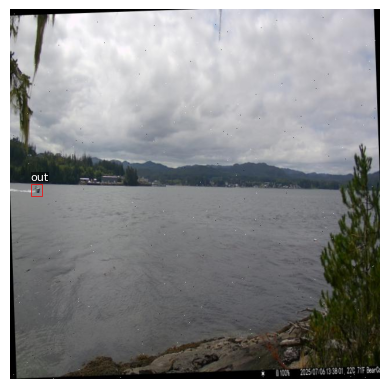

In [ ]:
# Visualize random images and their YOLO labels, with class name (in/out)
def plot_yolo_labels(img_path, label_path):
    class_names = ['in', 'out'] 
    img = Image.open(img_path)
    w, h = img.size
    boxes = []
    labels = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                # Convert YOLO format to box coordinates
                x1 = (x - bw/2) * w
                y1 = (y - bh/2) * h
                x2 = (x + bw/2) * w
                y2 = (y + bh/2) * h
                boxes.append((x1, y1, x2, y2))
                labels.append(int(cls))
    plt.imshow(img)
    ax = plt.gca()
    for box, cls in zip(boxes, labels):
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color='red', linewidth=0.5)
        ax.add_patch(rect)
        # Add class name label above the box
        ax.text(box[0], box[1] - 2, class_names[cls], color='white', fontsize=8, va='bottom', ha='left', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=0))
    plt.axis('off')
    plt.show()


    
img_dir = "img\\chokepoint v2\\train\\images"
label_dir = "img\\chokepoint v2\\train\\labels"
img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]
for i in range(3):
    img_file = random.choice(img_files)
    label_file = os.path.splitext(img_file)[0] + '.txt'
    print(f"Image: {img_file}")
    plot_yolo_labels(os.path.join(img_dir, img_file), os.path.join(label_dir, label_file))

## 3. Prepare YOLO-Compatible Dataset Structure

Ensure the dataset is in YOLO format:
- `/dataset/images/train`, `/dataset/images/val`, `/dataset/images/test`
- `/dataset/labels/train`, `/dataset/labels/val`, `/dataset/labels/test`

If not, split and organize the dataset accordingly.

In [3]:
# Printing number of images in train/test/valid splits - sanity check
splits = ['train', 'valid', 'test']
for split in splits:
    img_dir = os.path.join('img', 'chokepoint v2', split, 'images')
    label_dir = os.path.join('img', 'chokepoint v2', split, 'labels')
    num_imgs = len([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))])
    num_labels = len([f for f in os.listdir(label_dir) if f.endswith('.txt')])
    print(f"{split.capitalize()} - Images: {num_imgs}, Labels: {num_labels}")

Train - Images: 384, Labels: 384
Valid - Images: 44, Labels: 44
Test - Images: 20, Labels: 20


## 4. Configure YOLO Model and Training Parameters

Set up the YOLO model, number of classes, and training configuration.

In [4]:
# Define YOLO config YAML for custom dataset
yolo_yaml = '''
path: ./img/chokepoint v2
train: train/images
val: valid/images
nc: 2
names: ['in','out']
'''
with open('boat_data.yaml', 'w') as f:
    f.write(yolo_yaml)

# Choose YOLO model - v8n is small/fast, v8m/v8l for more accuracy
model = YOLO('yolov8n.pt')  

## 5. Train the YOLO Model

Train the model using the custom dataset and configuration.

In [5]:
import torch
torch.set_num_threads(4)

results = model.train(
    data='boat_data.yaml',
    epochs=50,
    imgsz=320,
    batch=4,
    lr0=0.002,
    lrf=0.01,
    patience=10,
    project='chokepoint',
    exist_ok=True,
    device='cpu'
)


New https://pypi.org/project/ultralytics/8.4.12 available  Update with 'pip install -U ultralytics'
Ultralytics 8.4.9  Python-3.11.14 torch-2.10.0+cpu CPU (Intel Core i7-6600U 2.60GHz)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=boat_data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, ops

In [8]:
model_trained = YOLO('runs/detect/chokepoint/train/weights/best.pt')  
fine_tuned = model_trained.train(
                data='boat_data.yaml',
                project = 'chokepoint_finetuned',
                epochs=20,
                patience=5,
                imgsz=416,
                batch=4,
                exist_ok=True,
                device='cpu'
            )

New https://pypi.org/project/ultralytics/8.4.12 available  Update with 'pip install -U ultralytics'
Ultralytics 8.4.9  Python-3.11.14 torch-2.10.0+cpu CPU (Intel Core i7-6600U 2.60GHz)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=boat_data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/chokepoint/train/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, n

## 6. Visualize Training Metrics

Plot training and validation loss, mAP, and other metrics to monitor model performance.

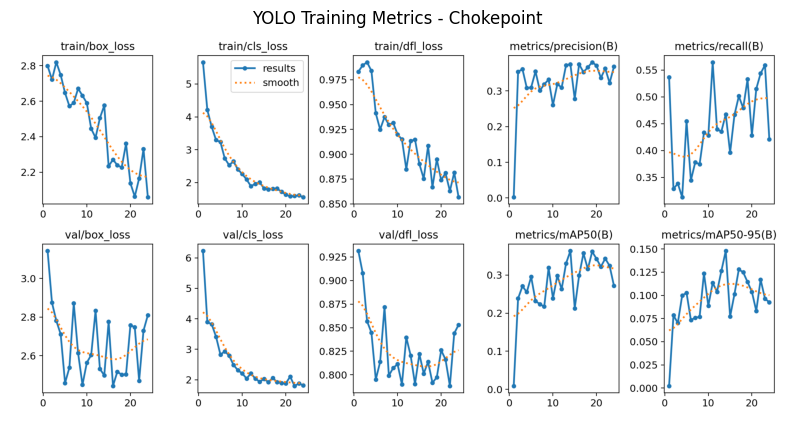

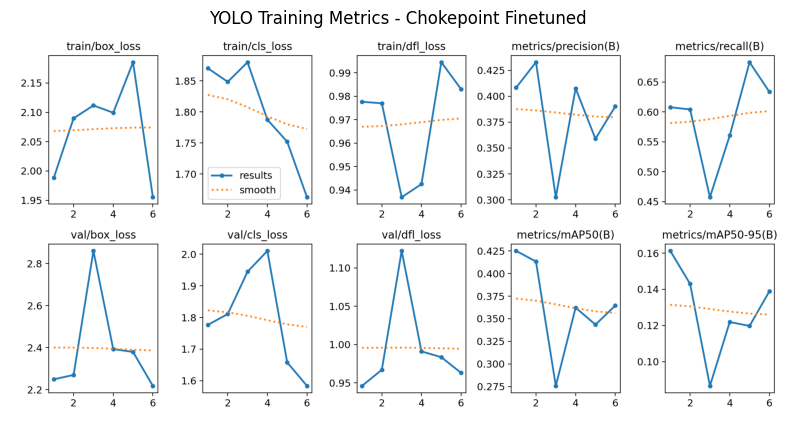

In [9]:
# Plot training results (loss, mAP, etc.)
results_path = 'runs\\detect\\chokepoint\\train\\results.png'
if os.path.exists(results_path):
    img = Image.open(results_path)
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title('YOLO Training Metrics - Chokepoint')
    plt.show()
else:
    print('Training results plot not found.')

results_path = 'runs\\detect\\chokepoint_finetuned\\train\\results.png'
if os.path.exists(results_path):
    img = Image.open(results_path)
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title('YOLO Training Metrics - Chokepoint Finetuned')
    plt.show()
else:
    print('Training results plot not found.')

## 7. Evaluate Model Performance on Validation Data

Evaluate the trained model on the validation set and display metrics and example predictions.

In [10]:
# Evaluate on validation set 
# P = precision, R = recall, mAP = mean average precision
metrics = model_trained.val(data='boat_data.yaml', split='val', name='val', exist_ok=True)  

Ultralytics 8.4.9  Python-3.11.14 torch-2.10.0+cpu CPU (Intel Core i7-6600U 2.60GHz)
Model summary (fused): 73 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 49.319.9 MB/s, size: 49.1 KB)
val: Scanning C:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v2\valid\labels.cache... 44 images, 6 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 44/44  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 2.6s/it 7.7s5.1ss
                   all         44         51      0.407      0.608      0.427      0.162
                    in         21         23       0.31      0.609      0.388      0.152
                   out         21         28      0.505      0.607      0.465      0.171
Speed: 1.8ms preprocess, 153.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to C:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\runs\detect\val


image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v2\valid\images\IM_02391_JPG.rf.ae31842b125c52a2287193e1db923c86.jpg: 416x416 1 in, 344.4ms
Speed: 8.1ms preprocess, 344.4ms inference, 9.8ms postprocess per image at shape (1, 3, 416, 416)


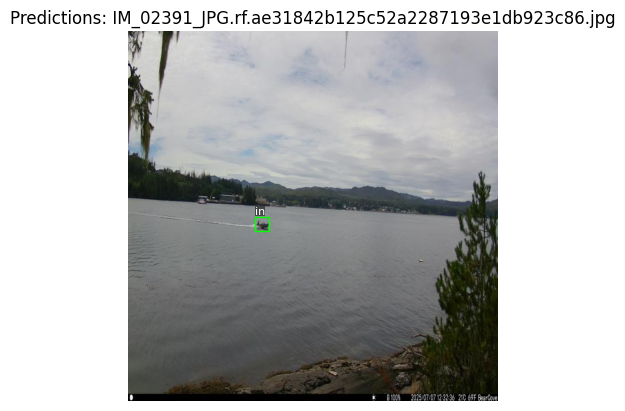


image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v2\valid\images\IM_03501_JPG.rf.07ef61e341cbf10e8e9230ea55dbfa77.jpg: 416x416 1 in, 216.5ms
Speed: 8.1ms preprocess, 216.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)


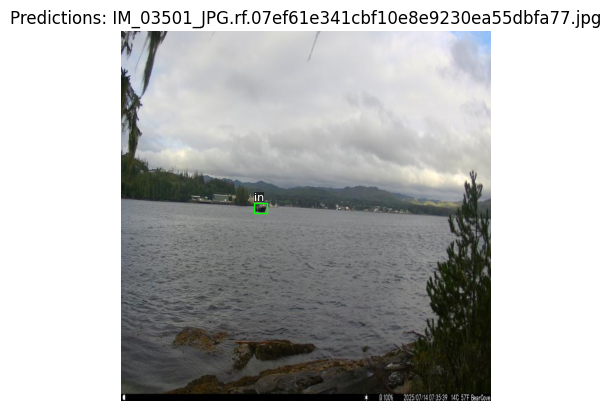


image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v2\valid\images\IM_03709_JPG.rf.f929bb00256ad85e05afca8e96704d17.jpg: 416x416 (no detections), 263.1ms
Speed: 3.3ms preprocess, 263.1ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)


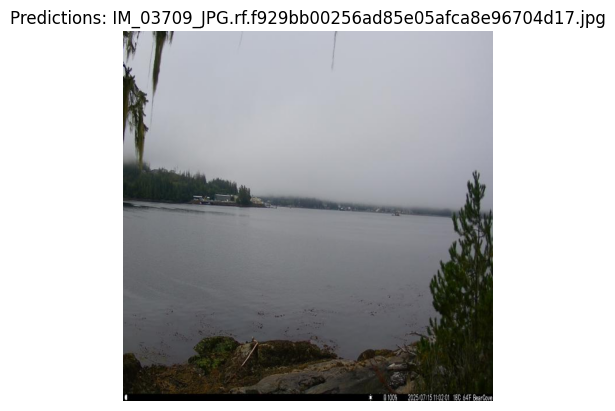

In [11]:
# Show predictions on a few random validation images

val_img_dir = 'img\\chokepoint v2\\valid\\images'
val_imgs = [os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir) if f.endswith(('.jpg', '.png'))]
for img_path in random.sample(val_imgs, min(3, len(val_imgs))):
    results = model_trained(img_path)
    # Get predicted boxes and classes from results[0]
    pred_boxes = results[0].boxes.xyxy.cpu().numpy() if results[0].boxes is not None else []
    pred_classes = results[0].boxes.cls.cpu().numpy().astype(int) if results[0].boxes is not None else []
    # Plot image and predicted boxes using the same logic as plot_yolo_labels
    img = Image.open(img_path)
    plt.imshow(img)
    ax = plt.gca()
    class_names = ['in', 'out']
    for box, cls in zip(pred_boxes, pred_classes):
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='lime', linewidth=1)
        ax.add_patch(rect)
        ax.text(x1, y1 - 2, class_names[cls], color='white', fontsize=8, va='bottom', ha='left', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=0))
    plt.axis('off')
    plt.title(f'Predictions: {os.path.basename(img_path)}')
    plt.show()

## 8. Run Inference on Sample Images

Use the trained model to predict boats in new images and visualize the results.


image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v1\test\images\IM_00706_JPG.rf.fc8e94a28048ab79e2da5511ce6d6b13.jpg: 416x416 (no detections), 322.9ms
Speed: 4.1ms preprocess, 322.9ms inference, 3.4ms postprocess per image at shape (1, 3, 416, 416)


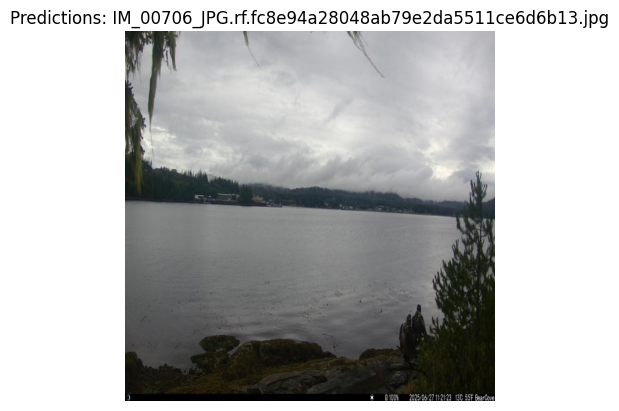


image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v1\test\images\IM_00051_JPG.rf.4af689e62e60e7f143046ac6cad3a556.jpg: 416x416 (no detections), 333.7ms
Speed: 16.4ms preprocess, 333.7ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 416)


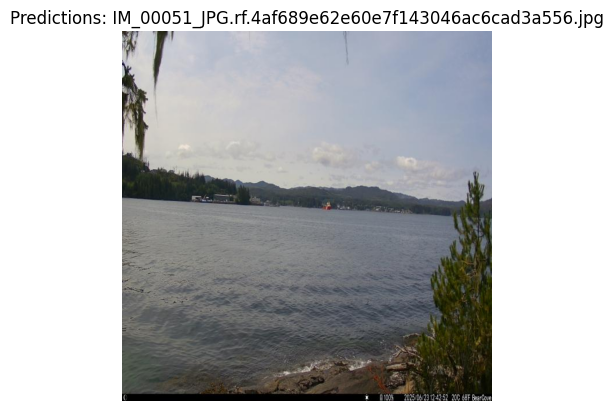


image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v1\test\images\IM_00817_JPG.rf.aa396d6103027093088dc880c7faa5fc.jpg: 416x416 1 out, 426.6ms
Speed: 2.9ms preprocess, 426.6ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)


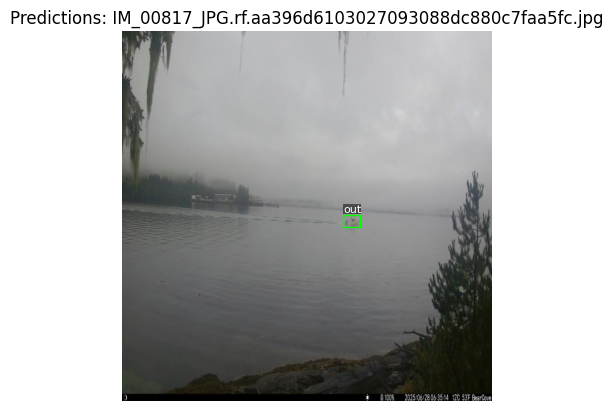

In [12]:
# Inference on new test images

test_img_dir = 'img\\chokepoint v1\\test\\images'  # or any folder with new images
test_imgs = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.png'))]
for img_path in random.sample(test_imgs, min(3, len(test_imgs))):
    results = model_trained(img_path)
    pred_boxes = results[0].boxes.xyxy.cpu().numpy() if results[0].boxes is not None else []
    pred_classes = results[0].boxes.cls.cpu().numpy().astype(int) if results[0].boxes is not None else []
    img = Image.open(img_path)
    plt.imshow(img)
    ax = plt.gca()
    class_names = ['in', 'out']
    for box, cls in zip(pred_boxes, pred_classes):
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='lime', linewidth=1)
        ax.add_patch(rect)
        ax.text(x1, y1 - 2, class_names[cls], color='white', fontsize=8, va='bottom', ha='left', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=0))
    plt.axis('off')
    plt.title(f'Predictions: {os.path.basename(img_path)}')
    plt.show()